In [37]:
import os 
import pandas as pd 
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms


Load the Data


In [38]:
benign ='data/archive/Dataset_BUSI_with_GT/benign'
malignant='data/archive/Dataset_BUSI_with_GT/malignant'
normal='data/archive/Dataset_BUSI_with_GT/normal'

In [39]:
count_benign=len(os.listdir(benign))
count_malignant=len(os.listdir(malignant))
count_normal=len(os.listdir(normal))

print((count_benign))
print(count_malignant)
print(count_normal)

891
421
266


Look at the data

In [40]:
def create_data(data_dir, categories):
    images = []
    masks = []
    labels = []

    for i, category in enumerate(categories):
        category_dir = os.path.join(data_dir, category)
        for file_name in os.listdir(category_dir):
            if "_mask" in file_name:
                continue
            image_file_path = os.path.join(category_dir, file_name)
            mask_file_name = file_name.replace(".", "_mask.")
            mask_file_path = os.path.join(category_dir, mask_file_name)
            if not os.path.exists(mask_file_path):
                continue
            images.append(image_file_path)
            masks.append(mask_file_path)
            labels.append(category)

    print(f"Found {len(images)} image/mask pairs in {len(categories)} categories")
    return images, masks, labels

In [41]:
data_dir ="data/archive/Dataset_BUSI_with_GT"

categories = ['normal','benign','malignant']

images,masks,labels=create_data(data_dir,categories)

id = [i for i in range(len(images))]

normal_labels = []
benign_labels = []
malignant_labels = []

for label in labels:
    normal_labels.append(float(1) if label=="normal" else float(0))
    benign_labels.append(float(1) if label=="benign" else float(0))
    malignant_labels.append(float(1)if label=="malignant" else float(0))



Found 647 image/mask pairs in 2 categories


In [6]:

images_df = pd.DataFrame({ "image":images})
#images_df.set_index('id')

labels_df = pd.DataFrame({ "normal": normal_labels, "benign":benign_labels, "malignant": malignant_labels},)
#labels_df.set_index('id')


In [ ]:
##OPTIONAL


In [7]:
from sklearn.model_selection import train_test_split

random_sample = 15

y = labels_df.sample(frac=1, random_state = random_sample)
display(y)
x = images_df.loc[y.index].image.to_frame()

# note that we are casting the species labels to an indicator/dummy matrix
x_train, x_eval, y_train, y_eval = train_test_split(
    x, y, stratify=y, test_size=0.25, random_state=random_sample
)

,normal,benign,malignant
434,0.0,1.0,0.0
353,0.0,1.0,0.0
175,0.0,1.0,0.0
656,1.0,0.0,0.0
94,0.0,1.0,0.0
...,...,...,...
156,0.0,1.0,0.0
384,0.0,1.0,0.0
645,0.0,0.0,1.0
757,1.0,0.0,0.0


In [8]:
split_pcts = pd.DataFrame(
    {
        "train": y_train.idxmax(axis=1).value_counts(normalize=True),
        "eval": y_eval.idxmax(axis=1).value_counts(normalize=True),
    }
)
print("Species percentages by split")
(split_pcts.fillna(0) * 100).astype(int)

Species percentages by split


,train,eval
benign,56,55
malignant,26,27
normal,17,16


In [9]:

# Use CUDA
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random

def plot_data(X,Y,label):
  
  index = Y[(Y[label] == 1)].sample(1).index[0]
  row = X.loc[index]
  
  img = cv2.imread(row['image'])

  fig, axs = plt.subplots(1, 2, figsize=(15, 5))
  axs[0].imshow(img)
  axs[0].set_title('Image')
  axs[1].text(0.5, 0.5, f'ID: {index}\nLabel: {label}', ha='center', va='center', fontsize=16)
  axs[1].axis('off')
  plt.show()

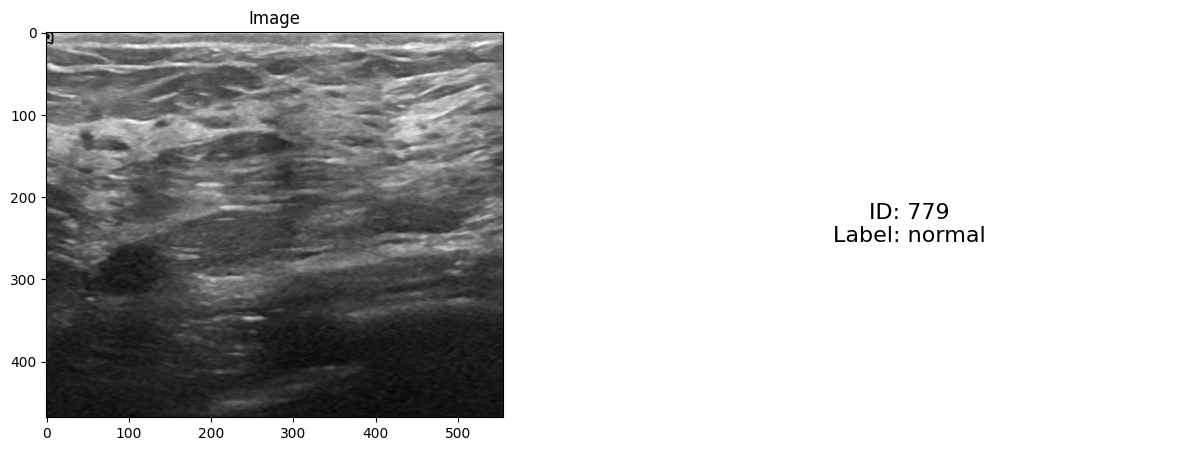

In [11]:
plot_data(x_train,y_train,"normal")

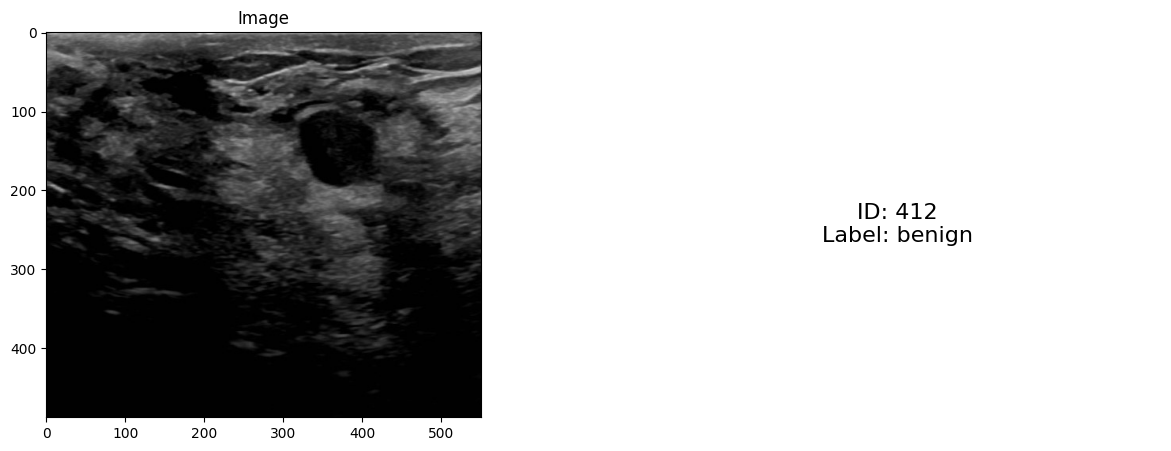

In [12]:
plot_data(x_train,y_train,"benign")

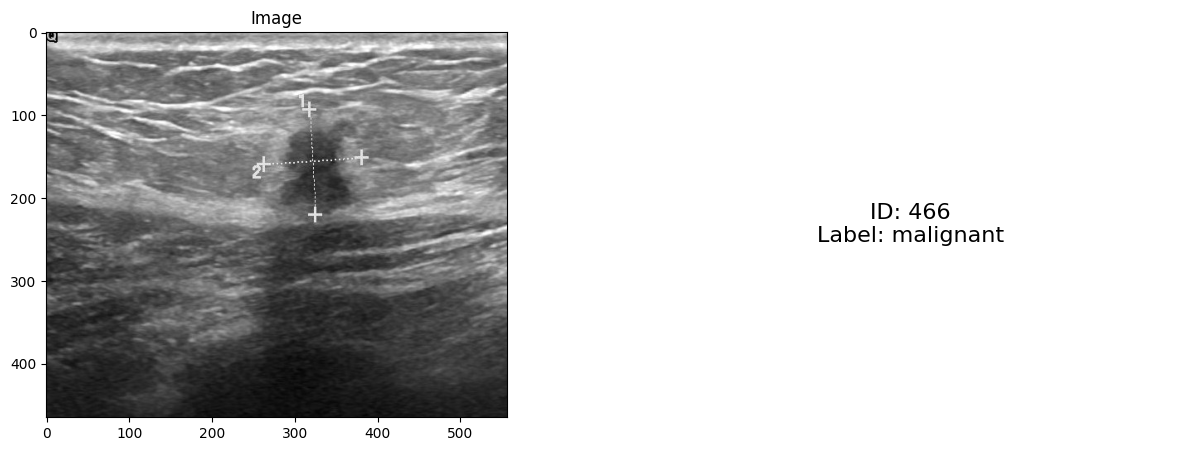

In [13]:
plot_data(x_train,y_train,"malignant")

In [14]:


class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None):
        self.data = x_df
        self.label = y_df
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __getitem__(self, index):
        image = Image.open(self.data.iloc[index]["image"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image": image}
        else:
            label = torch.tensor(self.label.iloc[index], 
                                 dtype=torch.float)
            sample = {"image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

In [15]:
from torch import nn
import torchvision.models as models

model = models.resnet152(pretrained = True)

model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(2048, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
    nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
    nn.Dropout(0.1),  # common technique to mitigate overfitting
    nn.Linear(
        100, 3
    ),  # final dense layer outputs 8-dim corresponding to our target classes
)

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [17]:
# Send model to GPU
# Send the model to GPU
model = model.to(DEVICE)

In [21]:

num_epochs = 8

tracking_loss = {}


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=num_epochs)


for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}")
    
    train_dataset = ImagesDataset(x_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=8)

    # iterate through the dataloader batches. tqdm keeps track of progress.
    for batch_n, batch in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        
        # 1) zero out the parameter gradients so that gradients from previous batches are not used in this step
        optimizer.zero_grad()

        # 2) run the forward step on this batch of images
        outputs = model(batch["image"].to(DEVICE))

        # 3) compute the loss
        loss = criterion(outputs, batch["label"].to(DEVICE))

        # let's keep track of the loss by epoch and batch
        tracking_loss[(epoch, batch_n)] = float(loss)

        # 4) compute our gradients
        loss.backward()
        # update our weights
        optimizer.step()

    print(f"The loss: {round(float(loss),2)} (Not averaged)")

Starting epoch 1


100%|██████████| 74/74 [00:13<00:00,  5.54it/s]


The loss: 2.56 (Not averaged)
Starting epoch 2


100%|██████████| 74/74 [00:13<00:00,  5.56it/s]


The loss: 3.5 (Not averaged)
Starting epoch 3


100%|██████████| 74/74 [00:13<00:00,  5.59it/s]


The loss: 3.14 (Not averaged)
Starting epoch 4


100%|██████████| 74/74 [00:13<00:00,  5.57it/s]


The loss: 2.37 (Not averaged)
Starting epoch 5


100%|██████████| 74/74 [00:13<00:00,  5.52it/s]


The loss: 1.69 (Not averaged)
Starting epoch 6


100%|██████████| 74/74 [00:13<00:00,  5.54it/s]


The loss: 1.66 (Not averaged)
Starting epoch 7


100%|██████████| 74/74 [00:13<00:00,  5.54it/s]


The loss: 2.59 (Not averaged)
Starting epoch 8


100%|██████████| 74/74 [00:13<00:00,  5.54it/s]

The loss: 2.55 (Not averaged)


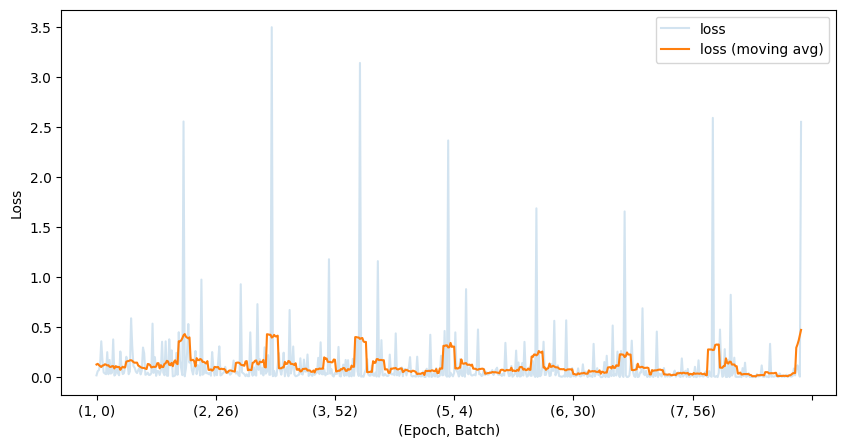

In [32]:
tracking_loss = pd.Series(tracking_loss)

plt.figure(figsize=(10, 5))
tracking_loss.plot(alpha=0.2, label="loss")
tracking_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="loss (moving avg)"
)
plt.xlabel("(Epoch, Batch)")
plt.ylabel("Loss")
plt.legend(loc=0)

In [23]:
torch.save(model, "model.pth")

In [24]:
loaded_model = torch.load("model.pth")

In [25]:
eval_dataset = ImagesDataset(x_eval, y_eval)
eval_dataloader = DataLoader(eval_dataset, batch_size=1)

In [26]:
actual_value = []
predicted_value = []

model = model.to("cpu")

for i in range(eval_dataloader.__len__()):
    actual_value.append(int(eval_dataset.__getitem__(i)['label'].argmax()))
    predicted_value.append(int(model(eval_dataset.__getitem__(i)['image'].to("cpu").unsqueeze(0)).argmax()))
    
    

In [29]:
true=0
for i in range(len(actual_value)):
    if actual_value[i]==predicted_value[i]:
        true+=1

print(f"Percent Correct: {round((true*100/len(actual_value)),2)}")

Percent Correct: 55.9


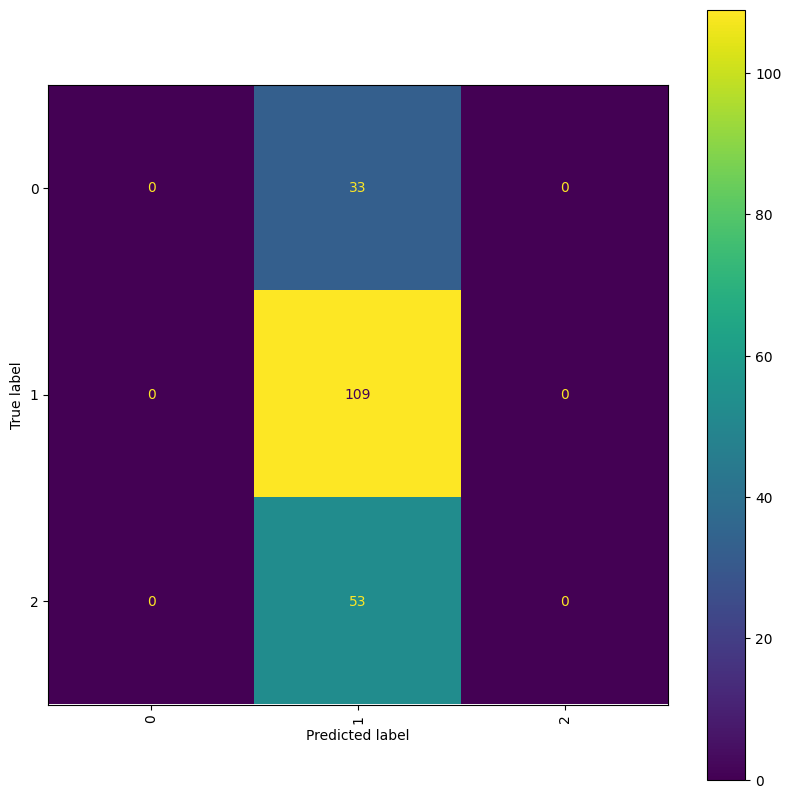

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    actual_value,
    predicted_value,
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

In [28]:
a= model(eval_dataset.__getitem__(100)['image'].to(DEVICE).unsqueeze(0))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
a.argmax()

tensor(2, device='cuda:0')

In [ ]:
eval_dataset.__getitem__(100)['label'].argmax()

tensor(1)

In [ ]:
for each thing in test set

make set of answers/predictions
copare witb kaves